## CPE 019 - Assignment 7.1 : Classifications and Regression


**Names:** SERRANO, Jio A.<br>
**Course and Section:** CPE019 - CPE32S3 <br>
**Date of Submission**: April 11, 2024<br>
**Instructor:** Engr. Roman Richard<br>


## Classification

### Rice (Cammeo and Osmancik) Classification Dataset

The dataset that was chosen for the classification task of this activity is a dataset from UCI Machine Learning Repository entitled "Rice (Cammeo and Osmancik)". Images of two rice varieties from Turkey, cammeo and osmancik, were processed and extracted for feature inferences. A total of 7 morphological features are identified from the images and are listed as follows:

* Area in pixels
* Perimeter in pixels
* Major_Axis_Length
* Minor_Axis_Length
* Eccentricity
* Convex_Area in pixels
* Extent

This is a binary classification problem with the classes being cammeo and osmancik represented by binary (1 and 0). The input features are integer and continuous variables.

The dataset can be accessed here:
https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik

#### Importing Classes and Functions

In [ ]:
!pip install keras
!pip install scikeras


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

#### Initialize Random Number Generator
A random number generator with a constant value will help us in reproducing the results of the training that we do here in our activity.

In [ ]:
seed = 11
np.random.seed(seed)

#### Loading the Dataset

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)

# data (as pandas dataframes)
X = rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets

# metadata
print(rice_cammeo_and_osmancik.metadata)

# variable information
print(rice_cammeo_and_osmancik.variables)


{'uci_id': 545, 'name': 'Rice (Cammeo and Osmancik)', 'repository_url': 'https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik', 'data_url': 'https://archive.ics.uci.edu/static/public/545/data.csv', 'abstract': "A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 3810, 'num_features': 7, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5MW4Z', 'creators': [], 'intro_paper': {'title': 'Classification of Rice Varieties Using Artificial Intelligence Methods', 'authors': 'Ilkay Cinar, M. Koklu', 'published_in': 'International Journal of Intelligent Systems and App

#### Verifying if the Dataset was Loaded

In [ ]:
X

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024
...,...,...,...,...,...,...,...
3805,11441,415.858002,170.486771,85.756592,0.864280,11628,0.681012
3806,11625,421.390015,167.714798,89.462570,0.845850,11904,0.694279
3807,12437,442.498993,183.572922,86.801979,0.881144,12645,0.626739
3808,9882,392.296997,161.193985,78.210480,0.874406,10097,0.659064


In [ ]:
y

,Class
0,Cammeo
1,Cammeo
2,Cammeo
3,Cammeo
4,Cammeo
...,...
3805,Osmancik
3806,Osmancik
3807,Osmancik
3808,Osmancik


The `X` variable contains the input features and the `y` variable contains the output variable or the target variable.

In [ ]:
# Combine the input features and target variable into one dataframe:

frames = [X, y]
riceDF = pd.concat(frames, axis=1)
riceDF.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


Combining the two dataframes, `X` and `y` into a single dataset will allow us to perform our pre-processing easier later on. The `riceDF` dataframe now contains the whole dataset imported using Python. We have used the `info()` method in order to check for the columns of the dataset. This also gives us a glimpse if there are null values in the dataset. From the above result, there are no null values in the chosen dataset. It can also be noted that the output variable, which is the column, `Class`, has an `object` data type, meaning, these values could be string values which we will need to convert later on.

#### Removing Outliers

Outliers are data points that are too far off the median of the dataset which may skew the results of our model [2]. In this section, we will identify if there are present outliers in the dataset through visualization means using a boxplot. Removal of outliers will be done using interquartile range [3].


[2] GfG, “Detect and Remove the Outliers using Python,” GeeksforGeeks, Feb. 23, 2021. https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/ (accessed Apr. 07, 2024).
‌

[3] S. Allwright, “Remove outliers from Pandas DataFrame (Updated 2022),” Stephen Allwright, May 11, 2022. https://stephenallwright.com/remove-outliers-pandas/ (accessed Apr. 07, 2024).
‌

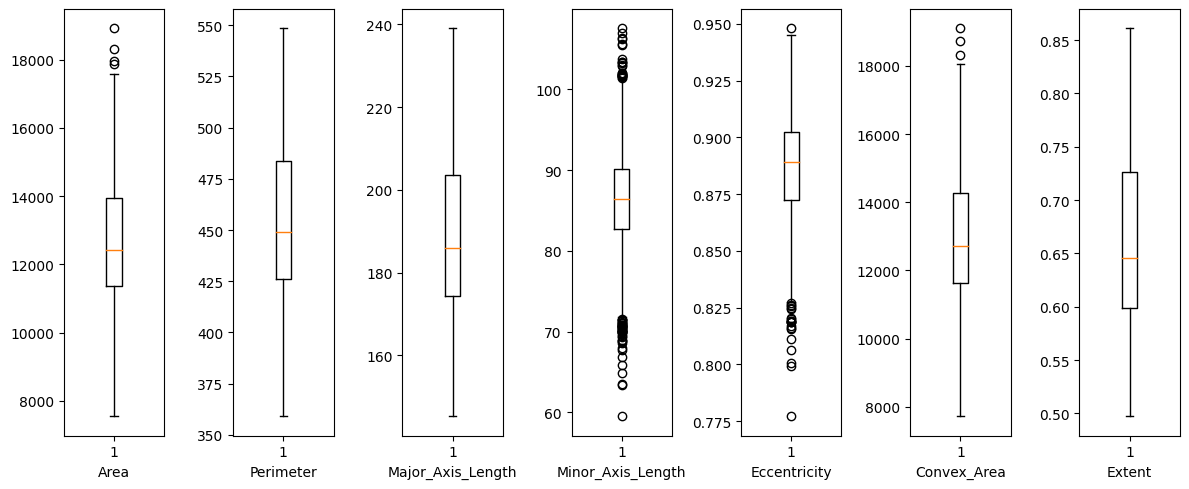

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 7, figsize=(12, 5))
features = riceDF.columns

for i in range(7):
  axs[i].boxplot(riceDF[features[i]])
  axs[i].set_xlabel(f"{features[i]}")


plt.tight_layout()
plt.show()

From the boxplots generated above, we can see that outliers are present in the `Area`, `Minor_Axis_Length`, `Eccentricity`, and `Convex_Area` columns. These are characterized by data points located outside the whiskers of the boxplots [4].


[4] “Box Plot Explained: Interpretation, Examples, & Comparison,” Simply Psychology, Jul. 31, 2023. https://www.simplypsychology.org/boxplots.html (accessed Apr. 07, 2024).
‌

To remove the outliers, we will use the interquartile range method where values that are located above the 75th percentile and below the 25th percentile are removed [3].  

In [ ]:
# Create function that will accept the dataframe, the column name to be cleaned, and threshold
# Return the cleaned dataframe

def remove_outliers_iqr(df, column_name, thresh=1.5):
  Q1 = df[column_name].quantile(0.25)
  Q3 = df[column_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - (thresh * IQR)
  upper_bound = Q3 + (thresh * IQR)

  return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

In [ ]:
# Remove outliers

dataDF = riceDF.copy()
features = dataDF.columns

for i in range((len(features)-1)):
  dataDF = remove_outliers_iqr(dataDF, f'{features[i]}')

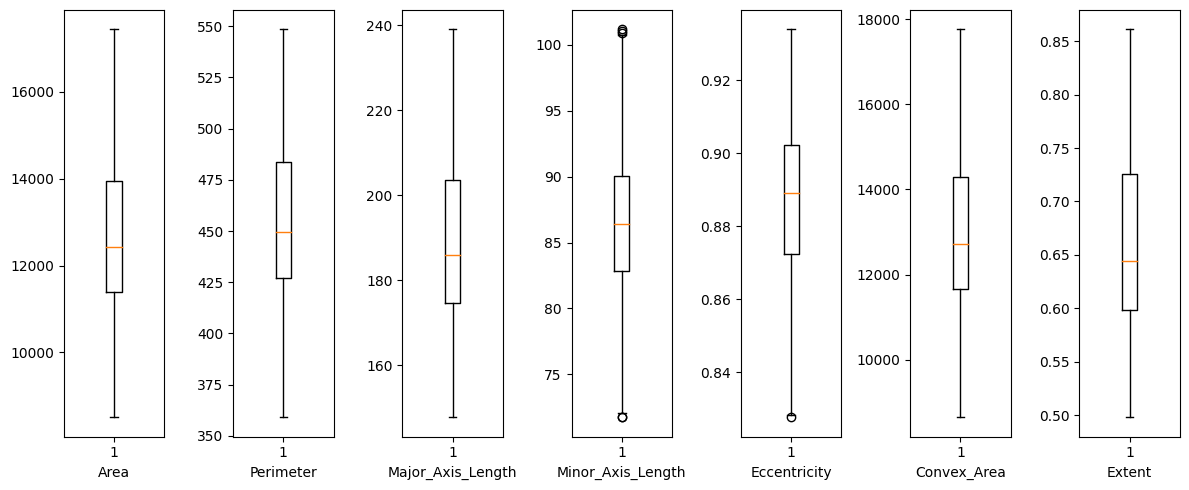

In [ ]:
# Verify if outliers were removed

fig, axs = plt.subplots(1, 7, figsize=(12, 5))
features = dataDF.columns

for i in range(7):
  axs[i].boxplot(dataDF[features[i]])
  axs[i].set_xlabel(f"{features[i]}")


plt.tight_layout()
plt.show()

In [ ]:
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3724 entries, 0 to 3808
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3724 non-null   int64  
 1   Perimeter          3724 non-null   float64
 2   Major_Axis_Length  3724 non-null   float64
 3   Minor_Axis_Length  3724 non-null   float64
 4   Eccentricity       3724 non-null   float64
 5   Convex_Area        3724 non-null   int64  
 6   Extent             3724 non-null   float64
 7   Class              3724 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 261.8+ KB


From the result of the boxplots above, we can see that we are able to remove the outliers from the dataset. Removing the outliers significantly reduced the size of our dataset to 3724 as seen in the result of the `info()` method above.

#### Scaling the Data

Some of the features in the dataset are expressed in a different scale from the others, hence, we will need to scale the data. Data scaling is useful when the input features are continuous variables that have different scales (e.g., some are in terms of pixels, some are of inches) [5].

[5] “Data Scaling for Machine Learning — The Essential Guide | Better Data Science,” Betterdatascience.com, 2024. https://betterdatascience.com/data-scaling-for-machine-learning/#:~:text=Scaling%20is%20a%20method%20of%20standardization%20that%E2%80%99s%20most,linear%20space%20%28like%20linear%20regression%20or%20K-nearest%20neighbors%29 (accessed Apr. 07, 2024).
‌

In [ ]:
X_new = dataDF.drop(columns = ["Class"])
y_new = dataDF["Class"]

print(X_new.shape)
print(y_new.shape)

(3724, 7)
(3724,)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_new)

In [ ]:
X_new

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024
...,...,...,...,...,...,...,...
3804,12501,451.799011,192.738800,83.195061,0.902043,12687,0.718820
3805,11441,415.858002,170.486771,85.756592,0.864280,11628,0.681012
3806,11625,421.390015,167.714798,89.462570,0.845850,11904,0.694279
3807,12437,442.498993,183.572922,86.801979,0.881144,12645,0.626739


In [ ]:
X_scaled

array([[ 1.51957877,  2.02910576,  2.36133042, ...,  2.09094683,
         1.53922971, -1.15150498],
       [ 1.17661155,  1.13494941,  0.98812641, ...,  0.41882958,
         1.22244291, -0.5981898 ],
       [ 1.16348933,  1.32972068,  1.45609093, ...,  1.25361845,
         1.15385421,  0.41402398],
       ...,
       [-0.63127302, -0.95033966, -1.22853446, ..., -2.05635796,
        -0.61898933,  0.42728712],
       [-0.14694367, -0.34669561, -0.31085172, ..., -0.29346455,
        -0.18827554, -0.45118509],
       [-1.67091103, -1.78229972, -1.60588285, ..., -0.630028  ,
        -1.66932647, -0.03074244]])

When we printed the `X_new` and `X_scaled` values, we can see that the `X_scaled` values showed values that are closer to each other compared to the ones in `X_new`.

#### Label Encoding

The `y` variable as seen earlier has string values, cammeo and osmancik. A technique called *one-hot encoding* will be used in converting this categorical variable into a numerical one. In *one-hot encoding*, separate columns for the categorical values will be made, forming a matrix, these columns will be filled with either 1 or 0 [1]. In our case, the one-hot encoded matrix will look like this:

```
Cammeo,      Osmancik,
1,           0,               
0,           1,                             
```

One-hot encoding is helpful in removing biases that may come from when we manually transform the labels arbitrarily to numerical values [1].

[1] GfG, “One Hot Encoding in Machine Learning,” GeeksforGeeks, Jun. 12, 2019. https://www.geeksforgeeks.org/ml-one-hot-encoding/ (accessed Apr. 07, 2024).
‌

In [ ]:
# Performing one-hot encoding on the target variable

encoder = LabelEncoder()
encoder.fit(y_new)
encoded_y = encoder.transform(y_new)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_y)

dummy_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

#### Creating Baseline Model

In [ ]:
# define baseline model
def baseline_model():
  model = Sequential()
  model.add(Dense(4, input_dim=7, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

We have used the `binary_crossentropy` for the loss function as the dataset used is a binary classification dataset. The `input_dim` was set to 7 which represents the number of input features in our dataset.

#### Evaluate Model with k-Cross Entropy Evaluation

In [ ]:
# Training dataset

estimator = KerasClassifier(baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 92.75% (1.16%)


In [ ]:
# Whole dataset

estimator = KerasClassifier(baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_scaled, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 92.43% (1.37%)


#### Adding Additional Hidden Layers

7 input variables
<br> 2 hidden layers
<br> Changed number of neurons

In [ ]:
# define baseline model
def baseline_model():
  model = Sequential()
  model.add(Dense(16, input_dim=7, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
estimator = KerasClassifier(baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 92.45% (1.70%)


In [ ]:
estimator = KerasClassifier(baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_scaled, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 92.40% (1.07%)


7 input variables
<br> 4 hidden layers
<br> Changed number of neurons

In [ ]:
# define baseline model
def baseline_model():
  model = Sequential()
  model.add(Dense(32, input_dim=7, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(4, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
estimator = KerasClassifier(baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_scaled, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 92.19% (1.24%)


## Regression

### Concrete Compressive Strength Dataset

The dataset used for the regression problem is from the UCI Machine Learning Repository and is entitled **Concrete Compressive Strength Dataset**. The dataset explores the relationship between the concrete's compressive strength and the ingredients used. An age attribute is also included in the dataset. There are a total of 8 input features, 7 of which are ingredients expressed in kg/m^3 and the age. The output variable is a continuous variable for the concrete compressive strength expressed in MPa. There are a total of 1030 instances in the said dataset.

The dataset can be accessed here: https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength

#### Loading the Dataset

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
concrete_compressive_strength = fetch_ucirepo(id=165)

# data (as pandas dataframes)
X = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets

# metadata
print(concrete_compressive_strength.metadata)

# variable information
print(concrete_compressive_strength.variables)


{'uci_id': 165, 'name': 'Concrete Compressive Strength', 'repository_url': 'https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength', 'data_url': 'https://archive.ics.uci.edu/static/public/165/data.csv', 'abstract': 'Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. ', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1030, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Concrete compressive strength'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5PK67', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'title': 'Modeling of strength of high-performance concrete using artificial neural networks', 'authors': 'I. Yeh', 'published_in': 'Cement and Concrete Res

#### Verifying if the Dataset was Loaded

In [ ]:
X

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


In [ ]:
y

,Concrete compressive strength
0,79.99
1,61.89
2,40.27
3,41.05
4,44.30
...,...
1025,44.28
1026,31.18
1027,23.70
1028,32.77


Printing the `X` and `y` variables above show some of the contents of each of the dataframe. This allows us to verify if the dataset has been properly loaded.

In [ ]:
# Combine the input features and target variable into one dataframe:

frames = [X, y]
concreteDF = pd.concat(frames, axis=1)
concreteDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Cement                         1030 non-null   float64
 1   Blast Furnace Slag             1030 non-null   float64
 2   Fly Ash                        1030 non-null   float64
 3   Water                          1030 non-null   float64
 4   Superplasticizer               1030 non-null   float64
 5   Coarse Aggregate               1030 non-null   float64
 6   Fine Aggregate                 1030 non-null   float64
 7   Age                            1030 non-null   int64  
 8   Concrete compressive strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Combining the two dataframes, `X` and `y` into a single dataset will allow us to perform our pre-processing easier later on. The `concreteDF` dataframe now contains the whole dataset imported using Python. We have used the `info()` method in order to check for the columns of the dataset. This also gives us a glimpse if there are null values in the dataset. From the above result, there are no null values in the chosen dataset. Upon checking the data types of the columns, all of the input variables, aside from `Age` have the same scales and are all `float64` values. The output variable, `Conccrete compressive strength` is also a `float64` value.

#### Handling Outliers

The same technique as in the classification problem earlier will be used to handle the outliers for the regression dataset.

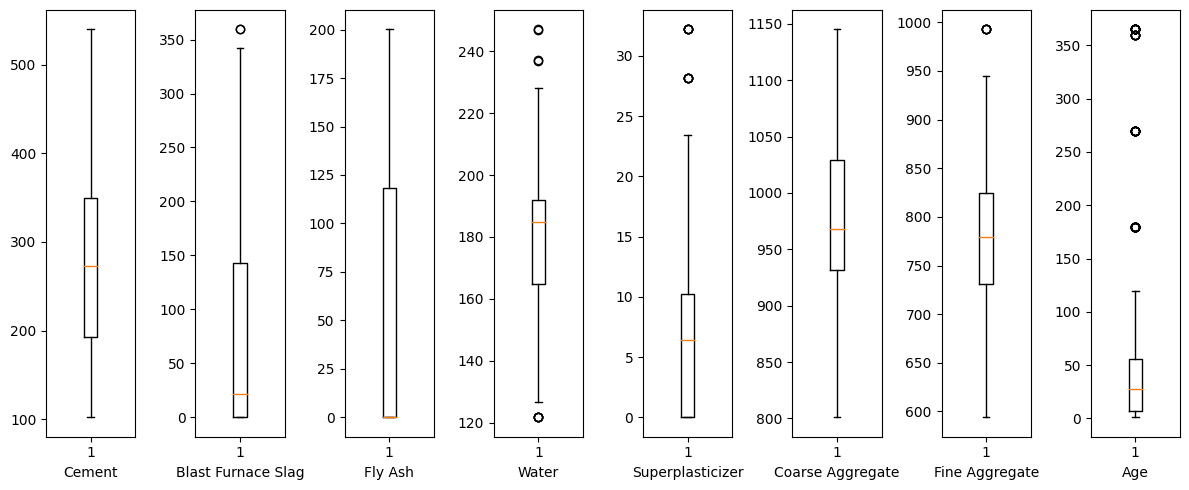

In [ ]:
# Check for outliers using boxplot

import matplotlib.pyplot as plt

no_of_features = len(X.columns)

fig, axs = plt.subplots(1, no_of_features, figsize=(12, 5))
features = concreteDF.columns

for i in range(no_of_features):
  axs[i].boxplot(concreteDF[features[i]])
  axs[i].set_xlabel(f"{features[i]}")


plt.tight_layout()
plt.show()

From what we can see in the boxplots generated above, there are a few outliers present in the Blast Furnace Slag, Water, Superplasticizer, Fine Aggregate. and Age variables. These are seen as those data points outside the whiskers of the box plots.

In [ ]:
# Remove outliers

data2DF = concreteDF.copy()
features = data2DF.columns

for i in range((len(features)-1)):
  data2DF = remove_outliers_iqr(data2DF, f'{features[i]}')

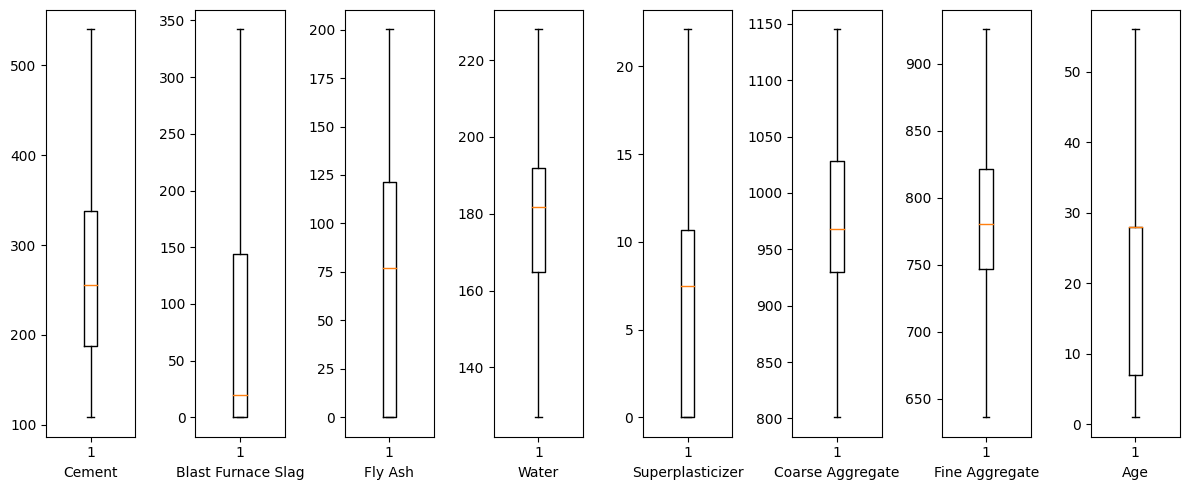

In [ ]:
# Verify if outliers were removed

no_of_features = len(X.columns)

fig, axs = plt.subplots(1, no_of_features, figsize=(12, 5))
features = concreteDF.columns

for i in range(no_of_features):
  axs[i].boxplot(data2DF[features[i]])
  axs[i].set_xlabel(f"{features[i]}")


plt.tight_layout()
plt.show()

In [ ]:
data2DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 763 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Cement                         763 non-null    float64
 1   Blast Furnace Slag             763 non-null    float64
 2   Fly Ash                        763 non-null    float64
 3   Water                          763 non-null    float64
 4   Superplasticizer               763 non-null    float64
 5   Coarse Aggregate               763 non-null    float64
 6   Fine Aggregate                 763 non-null    float64
 7   Age                            763 non-null    int64  
 8   Concrete compressive strength  763 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 59.6 KB


After removing the outliers, the number of instances of our dataframe is reduced to 763. We will now define the new `X` and `y` variables.

#### Defining `X_new2` and `y_new2`

`X_new2` and `y_new2` will now contain updated values after performing the pre-processing techniques.

In [ ]:
X_new2 = data2DF.drop(columns = ["Concrete compressive strength"])
X_new2

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28
11,198.6,132.4,0.0,192.0,0.0,978.4,825.5,28
14,304.0,76.0,0.0,228.0,0.0,932.0,670.0,28
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


In [ ]:
y_new2 = data2DF["Concrete compressive strength"]
y_new2

0       79.99
1       61.89
8       45.85
11      28.02
14      47.81
        ...  
1025    44.28
1026    31.18
1027    23.70
1028    32.77
1029    32.40
Name: Concrete compressive strength, Length: 763, dtype: float64

#### Creating Baseline Model

In [ ]:
def baseline_model():
	# create model
  model = Sequential()
  model.add(Dense(8, input_shape=(8,), kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))

  # Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

#### Evaluate Model (Without Standardization of Dataset)

In [ ]:
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_new2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: -61.25 (28.49) MSE


#### Standardizing the Dataset

One of the input features, specifically `Age`, has a different scale from the rest of the inputs. This could affect the performance of the model, hence, we will standardize the input features using the `StandardScaler` from `sklearn`.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled2 = scaler.fit_transform(X_new2)

#### Re-evaluating the Model with Standardized Dataset

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X_new2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -65.54 (28.35) MSE


In [ ]:
# evaluate model with standardized dataset
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_scaled2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Baseline: -63.42 (27.85) MSE


When standardization was done on the dataset, the MSE was reduced to -65.54 and the standard deviation was reduced by a bit (from 28.49 to 28.35).

#### Evaluating Smaller Network

For the smaller network, the number of neurons for the input layer will be reduced by half.

In [ ]:
def smaller_model():
	# create model
  model = Sequential()
  model.add(Dense(4, input_shape=(8,), kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))

  # Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=smaller_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X_new2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Standardized (Smaller Model): %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized (Smaller Model): -65.58 (28.52) MSE


In [ ]:
# evaluate model with standardized dataset
estimator = KerasRegressor(model=smaller_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_scaled2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Smaller Model (Standardized Data): %.2f (%.2f) MSE" % (results.mean(), results.std()))

Smaller Model (Standardized Data): -63.49 (25.41) MSE


The smaller network did not improve the performance of the model. Quite the contrary, there is a slight increase in the MSE (-64.91) and the standard deviation (28.55).

#### Evaluating Larger Network

For the larger network, the number of neurons for the first layer was more than twice the original (from 8 to 20). Additional two hidden layers were also introduced in the model.

In [ ]:
def larger_model():
	# create model
  model = Sequential()
  model.add(Dense(20, input_shape=(8,), kernel_initializer='normal', activation='relu'))
  model.add(Dense(10, kernel_initializer='normal'))
  model.add(Dense(5, kernel_initializer='normal'))
  model.add(Dense(1, kernel_initializer='normal'))

  # Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=larger_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X_new2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Standardized (Larger Model): %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized (Larger Model): -65.08 (31.62) MSE


In [ ]:
# evaluate model with standardized dataset
estimator = KerasRegressor(model=larger_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_scaled2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Larger Model (Standardized Data): %.2f (%.2f) MSE" % (results.mean(), results.std()))

Larger Model (Standardized Data): -69.58 (33.39) MSE


#### Evaluating a Deeper Network

A deeper network consists of more hidden layers. In our case, the total number of hidden layers is changed from 1 to 3. The first one has 8 neurons and the succeeding ones will have half the number of neurons of the layer preceeding them.

In [ ]:
def deeper_model():
	# create model
  model = Sequential()
  model.add(Dense(8, input_shape=(8,), kernel_initializer='normal', activation='relu'))
  model.add(Dense(4, kernel_initializer='normal'))
  model.add(Dense(2, kernel_initializer='normal'))
  model.add(Dense(1, kernel_initializer='normal'))

  # Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=deeper_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X_new2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Standardized (Deeper Model): %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -67.43 (32.00) MSE


In [ ]:
# evaluate model with standardized dataset
estimator = KerasRegressor(model=deeper_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_scaled2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Deeper Model (Standardized Data): %.2f (%.2f) MSE" % (results.mean(), results.std()))

Deeper Model (Standardized Data): -65.80 (29.04) MSE


#### Evaluating a Wider Network

For a wider network, the number of neurons for the first layer was changed to more than twice the baseline model (from 8 to 20).

In [ ]:
def wider_model():
	# create model
  model = Sequential()
  model.add(Dense(20, input_shape=(8,), kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))

  # Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X_new2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Standardized (Wider Model): %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized (Wider Model): -59.77 (28.91) MSE


In [ ]:
# evaluate model with standardized dataset
estimator = KerasRegressor(model=wider_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_scaled2, y_new2, cv=kfold, scoring='neg_mean_squared_error')
print("Wider Model (Standardized Data): %.2f (%.2f) MSE" % (results.mean(), results.std()))

Wider Model (Standardized Data): -62.54 (28.38) MSE


### Summary of Results

**Table 1 Evaluation Results Summary (Using Pipeline Framework for Standardization)**

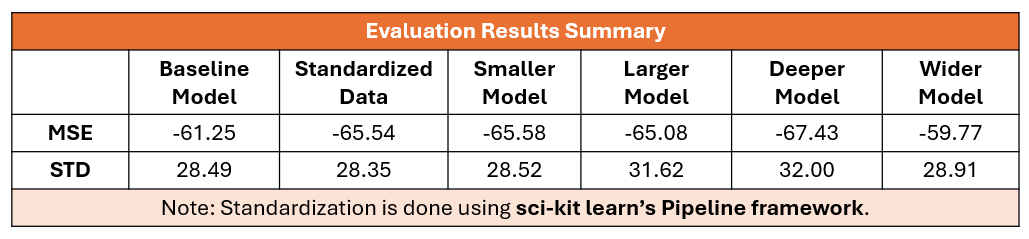

**Table 2. Evaluation Results Summary (Using StandardScaler for Standardization)**

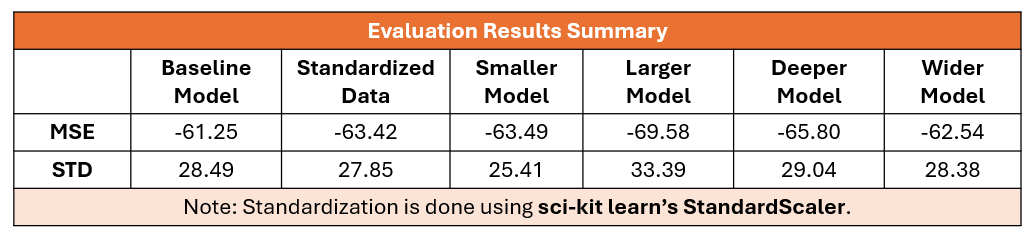

In the above evaluation, we have used the 10-fold cross validation to evaluate all of the created models. There are 5 models created: the baseline model, a smaller and a larger model, and a wider and a deeper model.

Two techniques for standardizing the data have been implemented for exploration—using sci-kit learn's Pipeline framework and the other using sci-kit learn's StandardScaler.

**Network Topology of Each Model**
* **Baseline Model**: 8 inputs -> [8] -> 1 output
* **Smaller Model**: 8 inputs -> [4] -> 1 output
* **Larger Model**: 8 inputs -> [20 -> 10 -> 5] -> 1 output
* **Deeper Model**: 8 inputs -> [8 -> 4 -> 2] -> 1 output
* **Wider Model**: 8 inputs -> [20] -> 1 output

Each of the model has different number of neurons set as well as the number of hidden layers. All of the models have been evaluated with the following parameters:

* `epochs` = 100
* `batch_size` = 5
* `verbose` = 1
* `n_splits` = 10

The results from the evaluation tests are summarized in Tables 1 and 2 above. Two values are obtained from the evaluation—MSE and standard deviation. MSE or mean squared error is a value that indicates the closeness of the regression line to a set of points [2]. According to [3], the smaller the value of the MSE is, the closer the model predictions are. Standard deviation on the other hand relates to the variance of the data points, a smaller value indicates better model performance [4].

Based on the summary table provided, excluding the baseline model, the smaller model has the least standard deviation value result out of all the other models. We can also notice that adding layers in the model (in larger and deeper models), resulted to an increase in the standard deviation and the MSE score. This indicates that the dataset used might not require that many layers for its model.

Another observation is that different STD values are obtained when the standardization technique used was through the `StandardScaler` in sci-kit learn. Lower values were obtained as compared to when the `Pipeline` framework was used.

[2] Mean, “Mean Squared Error: Definition and Example,” Statistics How To, Jan. 11, 2024. https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/mean-squared-error/ (accessed Apr. 08, 2024).
‌

[3] Zach, “An Easy Guide to K-Fold Cross-Validation - Statology,” Statology, Nov. 04, 2020. https://www.statology.org/k-fold-cross-validation/ (accessed Apr. 08, 2024).
‌

### Conclusion and Lessons Learned

In this activity, model creation for classification and regression problems has been explored. In addition to the creation of models, the evaluation of the models has also been done. Specifically, the k-fold cross validation was implemented.

Different pre-processing techniques were used for the chosen datasets including checking for null values, handling outliers, and scaling the dataset.

In the classification problem, running the cell for evaluating the model using k-fold cross validation took more than 30 minutes. This could be explained as the instances were over 3000 for the dataset after the pre-processing. The model obtained a score of around 92%.

For the regression model, different models were created, baseline, small, large, wide, and deep networks, to be specific. These models differ in terms of their number of hidden layers and the number of neurons per layer. Among the models, the small network showed the smallest value of standard deviation, indicating a relatively better performance compared to the other ones.

Overall, the activity has taught me new evaluation techniques that can be used when determining the performance of a neural network. I also learned some fine tuning techniques that could aid in improving the performance of the model.